# Endogenous optimization of clean cooking technologies

This minimal example simulates a single day of electrical consumption at a single house for a 24 hours snapshot.

This pypsa network will consists of
- 1  bio-diesel generator
- 1 gas store, 
- 1 pallet store
- 1 electric cooker
- 1 gas cooker 
- 1 bio-pallet cooker
- A constant baseload
- A variable cooking load
- 1 load-shedding generator

In [1]:
# Import essential modules into current workspace
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# show all pandas dataframe columns
pd.set_option('display.max_columns', None)

# Create a pypsa network
network = pypsa.Network() 

# create 24-hour snapshot with hourly resolution
index = pd.date_range(start = "2023-10-30 00:00", end = "2023-10-30 23:00", freq="H")

# assign created snapshot to pypsa network
network.set_snapshots(index)

# Add energy carriers to pypsa network

# add electricity
network.add("Carrier", name = "AC", nice_name = "electricity")

# add gas
network.add("Carrier", name = "gas",nice_name = "cooking gas")

# add solid biomass e.g pallets
network.add("Carrier", name ="solid biomass", nice_name = "pallets")

# add heat
network.add("Carrier", name ="heat")

# add electric bus to pypsa network
network.add("Bus", name = "electric bus", carrier = "AC")

# add diesel generator to pypsa network
network.add("Generator", name="diesel genset",
            bus= "electric bus", carrier = "AC",
            p_nom = 10.0, # energy capacity in MWh
            capital_cost= 5.5 ,
            p_max_pu = 1, # use generator at 100 percent
            marginal_cost= 3.5,
            control="PQ",
            efficiency = 0.85
              )

# add cooking bus to pypsa network
network.add("Bus", name = "cooking bus",carrier = "heat")

# add electric cooker to pypsa network
network.add("Link", name = "electric cooker", 
            bus0 = "electric bus", 
            bus1 = "cooking bus",
            efficiency = 0.85,
            capital_cost = 2.5,# cost of increasing capacity by 1MWh
            marginal_cost = 1.50,# cost of producing 1 MWh of energy
            p_nom= 10.5, # energy capacity in MWh
            p_max_pu = 1
            )

# add gas bus to pypsa network
network.add("Bus", name = "gas bus", carrier = "gas")

# add store for gas to pypsa network
network.add("Store",name = "gas store", bus = "gas bus",
            carrier = "gas", # energy carrier of store
            e_cyclic=False, # store is not cyclic
            e_nom = 30.0, # energy capacity in MWh
            e_initial = 30.0, # stored filled with 30 MWh of gas
            marginal_cost=0.001, # cost of producinh 1 MWh of energy
            capital_cost= 0.01, # cost of increasing capacity by 1MWh
              )

# add gas cooker to pypsa network
network.add("Link", name = "gas cooker",
            bus0 = "gas bus",
            bus1 = "cooking bus",
            efficiency = 0.90,
            capital_cost = 0.01,# cost of increasing capacity by 1MWh
            marginal_cost = 0.0001,# cost of producing 1 MWh of energy
            p_nom= 10.0, # energy capacity in MWh
            p_max_pu = 1,
            )

# add biomass bus to pypsa network
network.add("Bus", name = "biomass bus",
            carrier = "solid biomass")

# add stores: bio-pallet to pypsa network
network.add("Store", name = "pallet store",
            bus = "biomass bus", carrier = "solid biomass",
            e_cyclic=True,
            e_nom = 7.5, # energy capacity in MWh
            marginal_cost=0.4, # cost of producinh 1 MWh of energy
            capital_cost= 0.8, # cost of increasing capacity by 1MWh
  
            )

# add pallet cooker to pypsa network
network.add("Link", name = "pallet cooker",
            bus0 = "biomass bus",
            bus1 = "cooking bus",
            efficiency = 0.75,
            capital_cost = 1.0,# cost of increasing capacity by 1MWh
            marginal_cost = 0.85,# cost of producing 1 MWh of energy
            p_nom= 1.0, # energy capacity in MWh
            p_max_pu = 1)

# add two loads 

# create 24 hours snapshot
date = pd.date_range(start = "2023-10-30 00:00", end = "2023-10-30 23:00", freq="H")

# create constant base_load
base_load = pd.Series(data = 0.5, index = date ) 

# add base_load to pypsa network
network.add("Load", name = "electric load",
  bus = "electric bus", p_set = base_load.values)

# create  time-vvarying load for cooking time series
cooking_data = [0.1, 0.1, 0.1, 0.3, 0.5, 1.2,\
                1.3,1.5,1.6, 1.8, 2.0,2.0,\
                1.9, 1.8,1.7,1.6,1.5, 1.5, \
                1.4,1.4,1.2, 1.0,0.5,0.1,] 

cooking_load = pd.Series(data = cooking_data, index = date)

# add base_load to pypsa network
network.add(class_name = "Load", name = "cooking load",
           bus = "cooking bus", p_set = cooking_load.values,
          )

/home/giftsichone/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


- Display network load details

In [11]:
network.loads_t

{'p_set': Load                 electric load  cooking load
 snapshot                                        
 2023-09-10 00:00:00            0.5           0.1
 2023-09-10 01:00:00            0.5           0.1
 2023-09-10 02:00:00            0.5           0.1
 2023-09-10 03:00:00            0.5           0.3
 2023-09-10 04:00:00            0.5           0.5
 2023-09-10 05:00:00            0.5           1.2
 2023-09-10 06:00:00            0.5           1.3
 2023-09-10 07:00:00            0.5           1.5
 2023-09-10 08:00:00            0.5           1.6
 2023-09-10 09:00:00            0.5           1.8
 2023-09-10 10:00:00            0.5           2.0
 2023-09-10 11:00:00            0.5           2.0
 2023-09-10 12:00:00            0.5           1.9
 2023-09-10 13:00:00            0.5           1.8
 2023-09-10 14:00:00            0.5           1.7
 2023-09-10 15:00:00            0.5           1.6
 2023-09-10 16:00:00            0.5           1.5
 2023-09-10 17:00:00            0.5      

* Display graphs of generation and load 

Text(0, 0.5, 'Power (MW)')

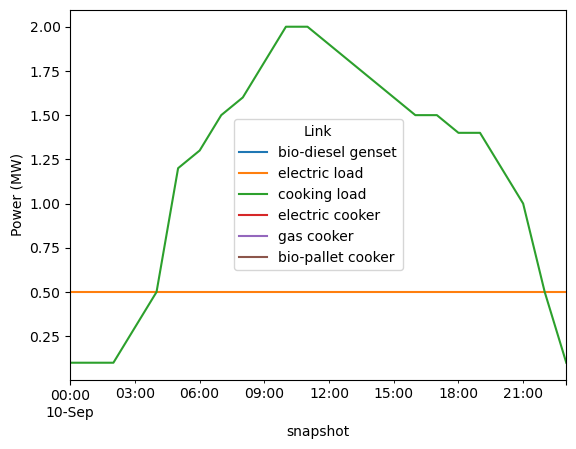

In [12]:
fig, ax = plt.subplots()

(network.generators_t.p_max_pu * network.generators.p_nom).plot(ax=ax)
network.loads_t.p_set.plot(ax=ax)
(network.links_t.p_max_pu * network.links.p_nom).plot(ax=ax)

ax.set_ylabel("Power (MW)")

* Optimize network

In [13]:
network.optimize()

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 192 primals, 432 duals
Objective: 4.85e+01
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-i17cm3gl.lp --output /tmp/linopy-solve-za20qkpx.sol
Reading problem data from '/tmp/linopy-problem-i17cm3gl.lp'...
432 rows, 192 columns, 647 non-zeros
2284 lines were read
GLPK Simplex Optimizer 5.0
432 rows, 192 columns, 647 non-zeros
Preprocessing...
120 rows, 143 columns, 286 non-zeros
Scaling...
 A: min|aij| =  7.500e-01  max|aij| =  1.000e+00  ratio =  1.333e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 119
*     0: obj =   2.072941176e+02 inf =   0.000e+00 (48)
*    24: obj =   4.850358824e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.3 Mb (324516 bytes)
Writing basic solution to '/tmp/linopy-solve-za20qkpx.sol'...


('ok', 'optimal')

* Add load shedding generator to pypsa network

In [14]:
# Add load shedding as generator
network.add(class_name = "Generator",
            name = "load shedding",
            bus="cooking bus",
            p_nom=2.0,
            carrier="load",
            p_max_pu=1,
            marginal_cost=1000,  # 100 €/MWh
            p_nom_extendable=True)

* Display graphs of generation and load with loadshedding generator added

Text(0, 0.5, 'Power (MW)')

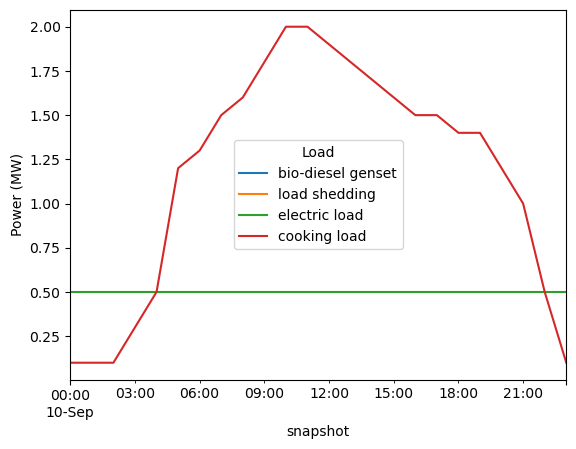

In [15]:
fig, ax = plt.subplots()

(network.generators_t.p_max_pu * network.generators.p_nom).plot(ax=ax)
network.loads_t.p_set.plot(ax=ax)

ax.set_ylabel("Power (MW)")

* Attempt optmizing with load shedding generator.

In [16]:
network.optimize()

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.11s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 217 primals, 481 duals
Objective: 4.85e+01
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-1mc29_3b.lp --output /tmp/linopy-solve-7lku7xn7.sol
Reading problem data from '/tmp/linopy-problem-1mc29_3b.lp'...
481 rows, 217 columns, 744 non-zeros
2574 lines were read
GLPK Simplex Optimizer 5.0
481 rows, 217 columns, 744 non-zeros
Preprocessing...
144 rows, 168 columns, 358 non-zeros
Scaling...
 A: min|aij| =  7.500e-01  max|aij| =  1.000e+00  ratio =  1.333e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 143
*     0: obj =   2.072941176e+02 inf =   0.000e+00 (48)
*    24: obj =   4.850358824e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.4 Mb (374596 bytes)
Writing basic solution to '/tmp/linopy-solve-7lku7xn7.sol'...


('ok', 'optimal')

<AxesSubplot:xlabel='snapshot'>

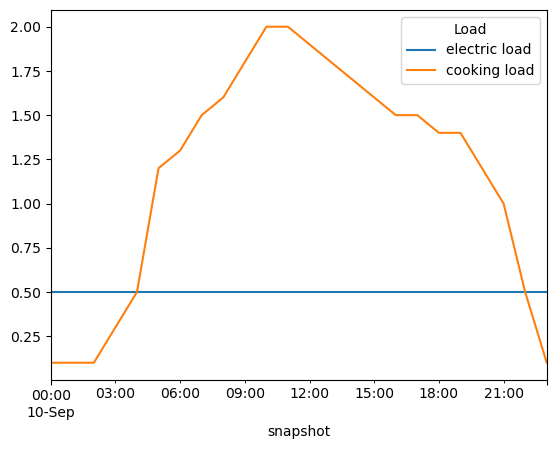

In [17]:
network.loads_t.p.plot()

* Plotting the optimization results after load shedding.

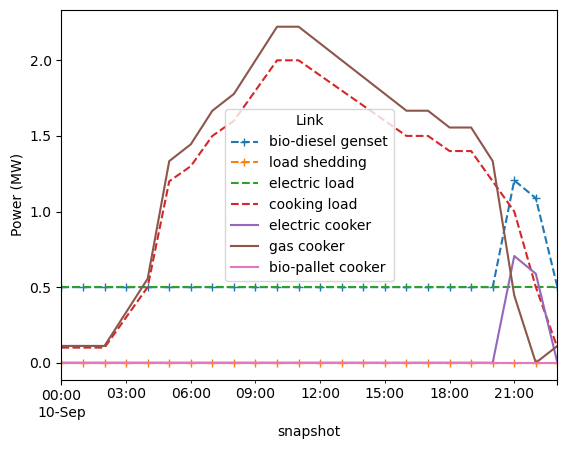

In [20]:
fig, ax = plt.subplots()

(network.generators_t.p).plot(ax=ax, style="--+")
network.loads_t.p_set.plot(ax=ax, style="--")
(network.links_t.p0).plot(ax=ax)
ax.set_ylabel("Power (MW)")
fig.savefig('cheap_gas_cooking_has_won.png')